In [1]:
!pip install efficientnet_pytorch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import datetime
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from collections import OrderedDict
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import optuna

DIR = os.getcwd()
n_epochs = 30
EPOCHS = 30

debug=True
train_the_model=True
test_the_network=True
display_on_console=False
confusion_matrix_on=True
find_std_and_mean=False


DEVICE = torch.device("cuda")

# define dataloader parameters

batch_size = 40
num_workers=8
name_of_csv="Results_of_Stage_II_Optimized_ML_Model"
path_to_save='Stage_II_Optimzied_Model.pth'
check_with_non_skew=False

if check_with_non_skew==True:
    batch_size = 10

In [2]:
# define training and test data directories
data_dir=os.path.join(DIR,'stage_2_images_with_additional_classes')

train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = sorted(os.listdir(train_dir))
print(classes)
N_classes = len(classes)


['Other', 'back ear tearing', 'exposed elastic', 'front ear tearing', 'hook creep', 'hook missing', 'tape tearing']


In [3]:
# percentage of training set to use as validation
valid_size = 0.2

# VGG-16 Takes 224x224 images as input, so we resize all of them
train_transforms = transforms.Compose([transforms.RandomRotation(40),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


percentage_train_data= round((len(train_data)*100/len(train_data+test_data)))
percentage_test_data=round((len(test_data)*100/len(train_data+test_data)))

# print out some data stats
print('Num training images: {} among {} batches.|| {}% out of Total Images'.format(len(train_data),len(train_data)/batch_size,percentage_train_data) )
print('Num test images: {} among {} batches. || {}% out of Total Images'.format(len(test_data),len(test_data)/batch_size,percentage_test_data) )

Num training images: 5274 among 131.85 batches.|| 84% out of Total Images
Num test images: 1004 among 25.1 batches. || 16% out of Total Images


In [4]:
#################################
#Prepare Dataloaders for Batches#
#################################

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders

test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, 
                                          num_workers=num_workers, shuffle=True)


In [5]:
def get_data():
    # Load datase
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                     sampler=train_sampler,num_workers=num_workers, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                    sampler=valid_sampler, num_workers=num_workers, shuffle=False)
    
    return train_loader, valid_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

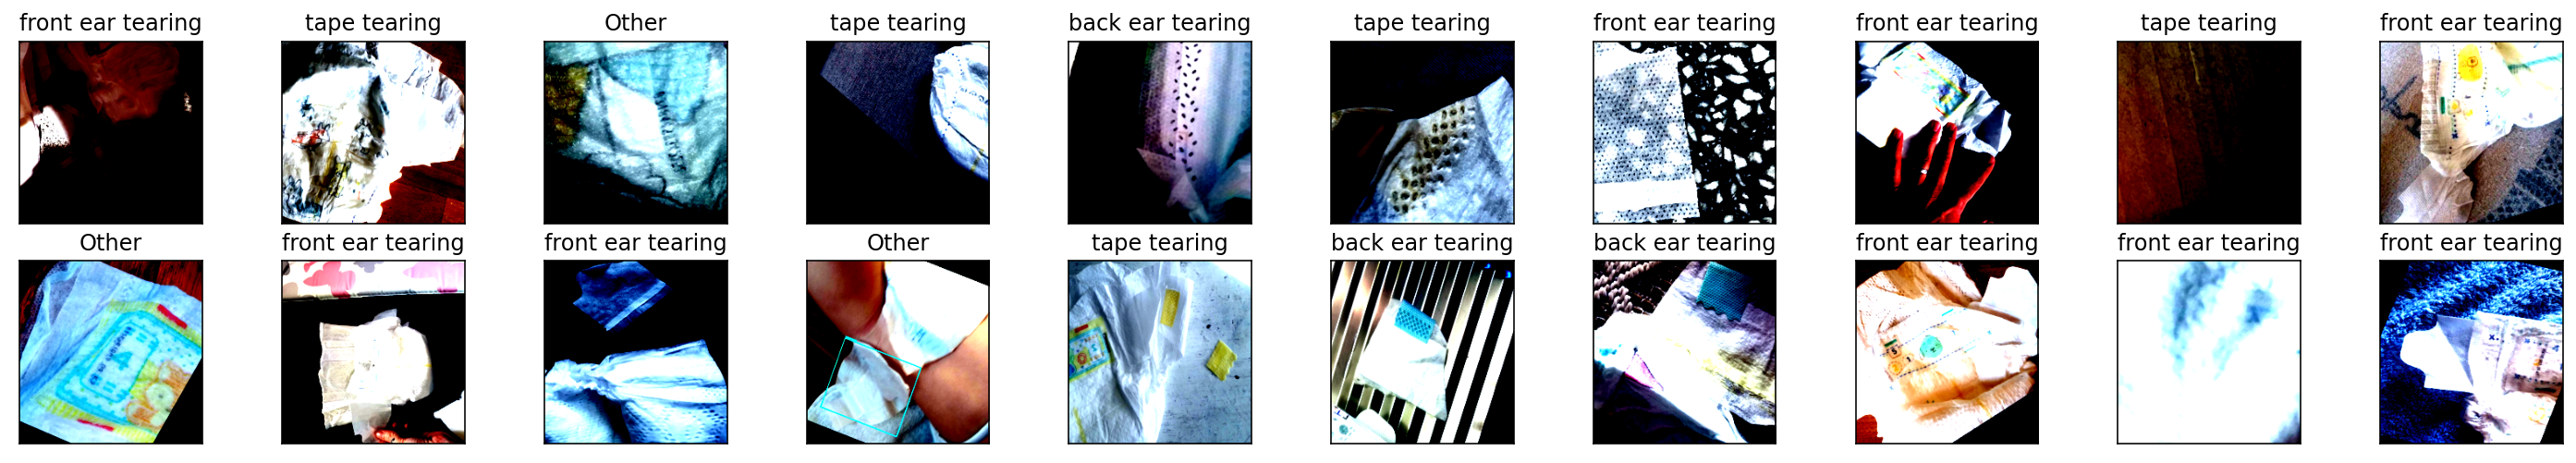

In [6]:
# Visualize some sample data
if check_with_non_skew==False:
    # obtain one batch of training images
    dataiter = iter(get_data()[0])
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    images.shape

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

In [7]:
num_GPUs = torch.cuda.device_count()

In [8]:
def define_model(trial):
    
    # We optimize the base_model, number of layers in Fully Connected classifier, hidden untis and 
    # dropout ratio in each layer.
    
    base_model = trial.suggest_categorical("base_model", ["VGG", "RESNET", "EfficientNet"])

    if base_model == "VGG":
        model = models.vgg19_bn(pretrained=True)
        in_features = 16000
        n_layers = trial.suggest_int("n_layers_v", 1, 3)
        layers = []
        if n_layers > 0:
            out_features = trial.suggest_int("n_units_l1_v", int(in_features/2), in_features)
            layers.append(nn.Linear(25088, out_features))
            layers.append(nn.ReLU())
            #p1 = trial.suggest_uniform("dropout_l1_v", 0.2, 0.6)
            p1 = 0.5
            layers.append(nn.Dropout(p1))
            in_features = out_features
            if n_layers > 1:
                out_features = trial.suggest_int("n_units_l2_v", int(in_features/2), in_features)
                layers.append(nn.Linear(in_features, out_features))
                layers.append(nn.ReLU())
                #p2 = trial.suggest_uniform("dropout_l2_v", 0.2, 0.6)
                p2 = 0.5
                layers.append(nn.Dropout(p2))
                in_features = out_features
                if n_layers > 2:
                    out_features = trial.suggest_int("n_units_l3_v", int(in_features/2), in_features)
                    layers.append(nn.Linear(in_features, out_features))
                    layers.append(nn.ReLU())
                    #p3 = trial.suggest_uniform("dropout_l3_v", 0.2, 0.6)
                    p3 = 0.6
                    layers.append(nn.Dropout(p3))
                    in_features = out_features
        layers.append(nn.Linear(in_features, N_classes))
        model.classifier = nn.Sequential(*layers)
        print('VGG is running.....')
        
    elif base_model == "RESNET":
        model = model = models.wide_resnet101_2(pretrained=True)
        in_features = model.fc.in_features
        n_layers = trial.suggest_int("n_layers_r", 1, 3)
        layers = []
        if n_layers > 0:
            out_features = trial.suggest_int("n_units_l1_r", int(in_features/2), in_features)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            #p1 = trial.suggest_uniform("dropout_l1_r", 0.2, 0.6)
            p1 = 0.5
            layers.append(nn.Dropout(p1))
            in_features = out_features
            if n_layers > 1:
                out_features = trial.suggest_int("n_units_l2_r", int(in_features/2), in_features)
                layers.append(nn.Linear(in_features, out_features))
                layers.append(nn.ReLU())
                #p2 = trial.suggest_uniform("dropout_l2_r", 0.2, 0.6)
                p2 = 0.5
                layers.append(nn.Dropout(p2))
                in_features = out_features
                if n_layers > 2:
                    out_features = trial.suggest_int("n_units_l3_r", int(in_features/2), in_features)
                    layers.append(nn.Linear(in_features, out_features))
                    layers.append(nn.ReLU())
                    #p3 = trial.suggest_uniform("dropout_l3_r", 0.2, 0.6)
                    p3 = 0.6
                    layers.append(nn.Dropout(p3))
                    in_features = out_features
        layers.append(nn.Linear(in_features, N_classes))
        model.fc = nn.Sequential(*layers)
        print('RESNET is running.....')
        
    elif base_model == "EfficientNet":
        from efficientnet_pytorch import EfficientNet
        
        base_model_efficientnet = trial.suggest_categorical("base_model_efficientnet", ["b0", "b1", "b2"])
        
        if base_model_efficientnet == "b0":
            model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=N_classes)
        elif base_model_efficientnet == "b1":
            model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=N_classes)
        elif base_model_efficientnet == "b2":
            model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=N_classes)
        
        in_features = model._fc.in_features

        n_layers = trial.suggest_int("n_layers_e", 1, 3)
        layers = []

        if n_layers > 0:
            out_features = trial.suggest_int("n_units_l1_e", int(in_features/2), in_features)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            #p1 = trial.suggest_uniform("dropout_l1_e", 0.2, 0.6)
            p1 = 0.5
            layers.append(nn.Dropout(p1))
            in_features = out_features
            if n_layers > 1:
                out_features = trial.suggest_int("n_units_l2_e", int(in_features/2), in_features)
                layers.append(nn.Linear(in_features, out_features))
                layers.append(nn.ReLU())
                #p2 = trial.suggest_uniform("dropout_l2_e", 0.2, 0.6)
                p2 = 0.5
                layers.append(nn.Dropout(p2))
                in_features = out_features
                if n_layers > 2:
                    out_features = trial.suggest_int("n_units_l3_e", int(in_features/2), in_features)
                    layers.append(nn.Linear(in_features, out_features))
                    layers.append(nn.ReLU())
                    #p3 = trial.suggest_uniform("dropout_l3:e", 0.2, 0.6)
                    p3 = 0.6
                    layers.append(nn.Dropout(p3))
                    in_features = out_features
        layers.append(nn.Linear(in_features, N_classes))
        model._fc = nn.Sequential(*layers)
        print('EfficientNet is running.....')

    return model

In [9]:
def objective(trial):
    
    DEVICE = torch.device("cuda")
    # Generate the model
    model = define_model(trial)
    model = torch.nn.DataParallel(model, device_ids=list(range(num_GPUs)))
    model.to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_loguniform("lr", 0.0001, 0.01)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()
    
    # Get the dataset.
    train_loader, valid_loader = get_data()
    valid_loss_min = np.Inf # track change in validation loss
    training_loss_array=[]
    valid_loss_array=[]
    
    # Training of the model.
    model.train()
    for epoch in range(EPOCHS):
        torch.cuda.empty_cache()

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        for data, target in train_loader:
    
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        print('Training done... Validating....')

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in valid_loader:
                
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                loss = criterion(output, target)
                # update average validation loss 
                valid_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        N_Valid_Examples = int(0.2*(len(train_loader.dataset)))
        accuracy = correct / (N_Valid_Examples*1.00)
        
        print('Accuracy for validation dataset is: ', accuracy)
        
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/(0.2*len(valid_loader.dataset))

        # print training/validation statistics 
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, EPOCHS, train_loss, valid_loss))
        
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [10]:
n = 35
sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(study_name = 'Optimization', sampler = sampler, direction="maximize", 
                            storage='sqlite:///stage_II_optimization_additional_classes.db',
                            load_if_exists=True)

study.optimize(objective, n_trials=n)

pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2020-08-08 20:17:15,699] Using an existing study with name 'Optimization' instead of creating a new one.


RESNET is running.....


C:\Users\makerspace.im\Anaconda3\envs\pyTorch\lib\site-packages\torch\nn\parallel\data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
C:\Users\makerspace.im\Anaconda3\envs\pyTorch\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.030119 	Validation Loss: 0.036500
Training done... Validating....
Accuracy for validation dataset is:  0.47722960151802657
Epoch: 1/30 	Training Loss: 0.026757 	Validation Loss: 0.034139
Training done... Validating....
Accuracy for validation dataset is:  0.5180265654648957
Epoch: 2/30 	Training Loss: 0.023766 	Validation Loss: 0.031647
Training done... Validating....
Accuracy for validation dataset is:  0.5664136622390892
Epoch: 3/30 	Training Loss: 0.021313 	Validation Loss: 0.028948
Training done... Validating....
Accuracy for validation dataset is:  0.5901328273244781
Epoch: 4/30 	Training Loss: 0.020678 	Validation Loss: 0.026420
Training done... Validating....
Accuracy for validation dataset is:  0.6176470588235294
Epoch: 5/30 	Training Loss: 0.019164 	Validation Loss: 0.026544
Training done... Validating....
Accuracy for validation dataset is:  0.612903225806451

[I 2020-08-08 21:58:33,225] Finished trial#18 with value: 0.6480075901328273 with parameters: {'base_model': 'RESNET', 'n_layers_r': 1, 'n_units_l1_r': 1081, 'optimizer': 'SGD', 'lr': 0.005507126923428527}. Best is trial#0 with value: 0.6650853889943074.


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.29886148007590135
Epoch: 0/30 	Training Loss: 0.038954 	Validation Loss: 0.048787
Training done... Validating....
Accuracy for validation dataset is:  0.35294117647058826
Epoch: 1/30 	Training Loss: 0.036374 	Validation Loss: 0.039899


[I 2020-08-08 22:05:29,329] Setting status of trial#19 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.26280834914611007
Epoch: 0/30 	Training Loss: 0.039004 	Validation Loss: 0.049435
Training done... Validating....
Accuracy for validation dataset is:  0.3510436432637571
Epoch: 1/30 	Training Loss: 0.038516 	Validation Loss: 0.048820


[I 2020-08-08 22:12:19,814] Setting status of trial#20 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b2
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.037094 	Validation Loss: 0.045807
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.033269 	Validation Loss: 0.039487


[I 2020-08-08 22:19:08,488] Setting status of trial#21 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b1
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.037509 	Validation Loss: 0.046735
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.034037 	Validation Loss: 0.040269


[I 2020-08-08 22:25:54,800] Setting status of trial#22 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b1
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3415559772296015
Epoch: 0/30 	Training Loss: 0.037535 	Validation Loss: 0.046013
Training done... Validating....
Accuracy for validation dataset is:  0.3519924098671727
Epoch: 1/30 	Training Loss: 0.032226 	Validation Loss: 0.038112


[I 2020-08-08 22:32:36,308] Setting status of trial#23 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b1
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.34819734345351044
Epoch: 0/30 	Training Loss: 0.038607 	Validation Loss: 0.048187
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.037028 	Validation Loss: 0.046282


[I 2020-08-08 22:39:22,522] Setting status of trial#24 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b0
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.2884250474383302
Epoch: 0/30 	Training Loss: 0.038366 	Validation Loss: 0.048530
Training done... Validating....
Accuracy for validation dataset is:  0.29316888045540795
Epoch: 1/30 	Training Loss: 0.037695 	Validation Loss: 0.047543


[I 2020-08-08 22:46:09,136] Setting status of trial#25 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.031509 	Validation Loss: 0.037144
Training done... Validating....
Accuracy for validation dataset is:  0.40132827324478176
Epoch: 1/30 	Training Loss: 0.027966 	Validation Loss: 0.034796
Training done... Validating....
Accuracy for validation dataset is:  0.5313092979127134
Epoch: 2/30 	Training Loss: 0.025941 	Validation Loss: 0.030789
Training done... Validating....
Accuracy for validation dataset is:  0.5294117647058824
Epoch: 3/30 	Training Loss: 0.024394 	Validation Loss: 0.029675
Training done... Validating....
Accuracy for validation dataset is:  0.6005692599620494
Epoch: 4/30 	Training Loss: 0.021991 	Validation Loss: 0.026738
Training done... Validating....
Accuracy for validation dataset is:  0.5929791271347249
Epoch: 5/30 	Training Loss: 0.020406 	Validation Loss: 0.028199
Training done... Validating....
Accuracy for validation dataset

[I 2020-08-09 00:27:03,984] Finished trial#26 with value: 0.650853889943074 with parameters: {'base_model': 'RESNET', 'n_layers_r': 2, 'n_units_l1_r': 1871, 'n_units_l2_r': 1310, 'optimizer': 'SGD', 'lr': 0.007587203311183411}. Best is trial#0 with value: 0.6650853889943074.


Loaded pretrained weights for efficientnet-b1
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35294117647058826
Epoch: 0/30 	Training Loss: 0.038395 	Validation Loss: 0.047187
Training done... Validating....
Accuracy for validation dataset is:  0.3548387096774194
Epoch: 1/30 	Training Loss: 0.034227 	Validation Loss: 0.040764


[I 2020-08-09 00:33:51,909] Setting status of trial#27 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.037939 	Validation Loss: 0.046060
Training done... Validating....
Accuracy for validation dataset is:  0.32637571157495254
Epoch: 1/30 	Training Loss: 0.029798 	Validation Loss: 0.036351


[I 2020-08-09 00:40:39,299] Setting status of trial#28 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b1
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.038407 	Validation Loss: 0.048301
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.037325 	Validation Loss: 0.046937


[I 2020-08-09 00:47:18,103] Setting status of trial#29 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.349146110056926
Epoch: 0/30 	Training Loss: 0.030000 	Validation Loss: 0.038073
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.030142 	Validation Loss: 0.037617


[I 2020-08-09 00:54:06,615] Setting status of trial#30 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.031706 	Validation Loss: 0.037509
Training done... Validating....
Accuracy for validation dataset is:  0.286527514231499
Epoch: 1/30 	Training Loss: 0.027727 	Validation Loss: 0.037015


[I 2020-08-09 01:00:54,321] Setting status of trial#31 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.031370 	Validation Loss: 0.037178
Training done... Validating....
Accuracy for validation dataset is:  0.16888045540796964
Epoch: 1/30 	Training Loss: nan 	Validation Loss: nan


[I 2020-08-09 01:07:40,225] Setting status of trial#32 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.030471 	Validation Loss: 0.036562
Training done... Validating....
Accuracy for validation dataset is:  0.4952561669829222
Epoch: 1/30 	Training Loss: 0.027387 	Validation Loss: 0.034377
Training done... Validating....
Accuracy for validation dataset is:  0.547438330170778
Epoch: 2/30 	Training Loss: 0.024318 	Validation Loss: 0.030011
Training done... Validating....
Accuracy for validation dataset is:  0.5
Epoch: 3/30 	Training Loss: 0.022262 	Validation Loss: 0.033197
Training done... Validating....
Accuracy for validation dataset is:  0.5161290322580645
Epoch: 4/30 	Training Loss: 0.021015 	Validation Loss: 0.030062
Training done... Validating....
Accuracy for validation dataset is:  0.5436432637571158
Epoch: 5/30 	Training Loss: 0.020463 	Validation Loss: 0.029815


[I 2020-08-09 01:28:01,597] Setting status of trial#33 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.032857 	Validation Loss: 0.038386
Training done... Validating....
Accuracy for validation dataset is:  0.36432637571157495
Epoch: 1/30 	Training Loss: 0.028037 	Validation Loss: 0.034965
Training done... Validating....
Accuracy for validation dataset is:  0.49430740037950666
Epoch: 2/30 	Training Loss: 0.026103 	Validation Loss: 0.031753
Training done... Validating....
Accuracy for validation dataset is:  0.33586337760910817
Epoch: 3/30 	Training Loss: 0.023391 	Validation Loss: 0.041525
Training done... Validating....
Accuracy for validation dataset is:  0.4108159392789374
Epoch: 4/30 	Training Loss: 0.021945 	Validation Loss: 0.032711


[I 2020-08-09 01:44:57,318] Setting status of trial#34 as TrialState.PRUNED. 


VGG is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3757115749525617
Epoch: 0/30 	Training Loss: 0.030016 	Validation Loss: 0.036540
Training done... Validating....
Accuracy for validation dataset is:  0.4686907020872865
Epoch: 1/30 	Training Loss: 0.027543 	Validation Loss: 0.034316
Training done... Validating....
Accuracy for validation dataset is:  0.3946869070208729
Epoch: 2/30 	Training Loss: 0.025352 	Validation Loss: 0.039654
Training done... Validating....
Accuracy for validation dataset is:  0.428842504743833
Epoch: 3/30 	Training Loss: 0.023773 	Validation Loss: 0.035204
Training done... Validating....
Accuracy for validation dataset is:  0.571157495256167
Epoch: 4/30 	Training Loss: 0.022545 	Validation Loss: 0.028842
Training done... Validating....
Accuracy for validation dataset is:  0.5787476280834914
Epoch: 5/30 	Training Loss: 0.022100 	Validation Loss: 0.027938
Training done... Validating....
Accuracy for validation dataset is:  0

[I 2020-08-09 02:23:01,509] Setting status of trial#35 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.031142 	Validation Loss: 0.037056
Training done... Validating....
Accuracy for validation dataset is:  0.39943074003795065
Epoch: 1/30 	Training Loss: 0.027484 	Validation Loss: 0.038614
Training done... Validating....
Accuracy for validation dataset is:  0.5161290322580645
Epoch: 2/30 	Training Loss: 0.025855 	Validation Loss: 0.030784
Training done... Validating....
Accuracy for validation dataset is:  0.5056925996204934
Epoch: 3/30 	Training Loss: 0.022711 	Validation Loss: 0.035438
Training done... Validating....
Accuracy for validation dataset is:  0.6110056925996205
Epoch: 4/30 	Training Loss: 0.021094 	Validation Loss: 0.026255
Training done... Validating....
Accuracy for validation dataset is:  0.5787476280834914
Epoch: 5/30 	Training Loss: 0.020085 	Validation Loss: 0.028777
Training done... Validating....
Accuracy for validation dataset

[I 2020-08-09 04:04:33,058] Finished trial#36 with value: 0.6774193548387096 with parameters: {'base_model': 'RESNET', 'n_layers_r': 2, 'n_units_l1_r': 1765, 'n_units_l2_r': 1505, 'optimizer': 'SGD', 'lr': 0.007480000794811768}. Best is trial#36 with value: 0.6774193548387096.


VGG is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.043292 	Validation Loss: 0.038010
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.029108 	Validation Loss: 0.037657


[I 2020-08-09 04:11:28,370] Setting status of trial#37 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.034177 	Validation Loss: 0.040145
Training done... Validating....
Accuracy for validation dataset is:  0.3908918406072106
Epoch: 1/30 	Training Loss: 0.028677 	Validation Loss: 0.035975
Training done... Validating....
Accuracy for validation dataset is:  0.3700189753320683
Epoch: 2/30 	Training Loss: 0.026953 	Validation Loss: 0.036960


[I 2020-08-09 04:21:33,036] Setting status of trial#38 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.035204 	Validation Loss: 0.041015
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.028575 	Validation Loss: 0.035990


[I 2020-08-09 04:28:22,833] Setting status of trial#39 as TrialState.PRUNED. 


Loaded pretrained weights for efficientnet-b0
EfficientNet is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.4108159392789374
Epoch: 0/30 	Training Loss: 0.028404 	Validation Loss: 0.063404
Training done... Validating....
Accuracy for validation dataset is:  0.16318785578747627
Epoch: 1/30 	Training Loss: 73.326326 	Validation Loss: 0.051772
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 2/30 	Training Loss: 0.846134 	Validation Loss: 0.038115


[I 2020-08-09 04:38:24,880] Setting status of trial#40 as TrialState.PRUNED. 


VGG is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.39753320683111953
Epoch: 0/30 	Training Loss: 0.029642 	Validation Loss: 0.036459
Training done... Validating....
Accuracy for validation dataset is:  0.4573055028462998
Epoch: 1/30 	Training Loss: 0.027038 	Validation Loss: 0.033454
Training done... Validating....
Accuracy for validation dataset is:  0.5028462998102466
Epoch: 2/30 	Training Loss: 0.025177 	Validation Loss: 0.032221
Training done... Validating....
Accuracy for validation dataset is:  0.49146110056925996
Epoch: 3/30 	Training Loss: 0.023501 	Validation Loss: 0.032411
Training done... Validating....
Accuracy for validation dataset is:  0.5521821631878557
Epoch: 4/30 	Training Loss: 0.022256 	Validation Loss: 0.029213
Training done... Validating....
Accuracy for validation dataset is:  0.5740037950664136
Epoch: 5/30 	Training Loss: 0.021625 	Validation Loss: 0.029166
Training done... Validating....
Accuracy for validation dataset is

[I 2020-08-09 05:29:43,770] Setting status of trial#41 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.031403 	Validation Loss: 0.037488
Training done... Validating....
Accuracy for validation dataset is:  0.4715370018975332
Epoch: 1/30 	Training Loss: 0.027479 	Validation Loss: 0.034021
Training done... Validating....
Accuracy for validation dataset is:  0.50853889943074
Epoch: 2/30 	Training Loss: 0.025539 	Validation Loss: 0.031542
Training done... Validating....
Accuracy for validation dataset is:  0.16888045540796964
Epoch: 3/30 	Training Loss: nan 	Validation Loss: nan
Training done... Validating....
Accuracy for validation dataset is:  0.16888045540796964
Epoch: 4/30 	Training Loss: nan 	Validation Loss: nan


[I 2020-08-09 05:46:52,334] Setting status of trial#42 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.031337 	Validation Loss: 0.037226
Training done... Validating....
Accuracy for validation dataset is:  0.45351043643263755
Epoch: 1/30 	Training Loss: 0.027607 	Validation Loss: 0.036924
Training done... Validating....
Accuracy for validation dataset is:  0.43548387096774194
Epoch: 2/30 	Training Loss: 0.025360 	Validation Loss: 0.035080
Training done... Validating....
Accuracy for validation dataset is:  0.5
Epoch: 3/30 	Training Loss: 0.022322 	Validation Loss: 0.033345
Training done... Validating....
Accuracy for validation dataset is:  0.573055028462998
Epoch: 4/30 	Training Loss: 0.021346 	Validation Loss: 0.028847
Training done... Validating....
Accuracy for validation dataset is:  0.611954459203036
Epoch: 5/30 	Training Loss: 0.019776 	Validation Loss: 0.026018
Training done... Validating....
Accuracy for validation dataset is:  0.62618595

[I 2020-08-09 07:28:35,310] Finished trial#43 with value: 0.6821631878557874 with parameters: {'base_model': 'RESNET', 'n_layers_r': 2, 'n_units_l1_r': 1939, 'n_units_l2_r': 1271, 'optimizer': 'SGD', 'lr': 0.007777499621984542}. Best is trial#43 with value: 0.6821631878557874.


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.030560 	Validation Loss: 0.036682
Training done... Validating....
Accuracy for validation dataset is:  0.4430740037950664
Epoch: 1/30 	Training Loss: 0.027573 	Validation Loss: 0.033218
Training done... Validating....
Accuracy for validation dataset is:  0.49146110056925996
Epoch: 2/30 	Training Loss: 0.025591 	Validation Loss: 0.031744
Training done... Validating....
Accuracy for validation dataset is:  0.5588235294117647
Epoch: 3/30 	Training Loss: 0.022541 	Validation Loss: 0.028636
Training done... Validating....
Accuracy for validation dataset is:  0.4838709677419355
Epoch: 4/30 	Training Loss: 0.021378 	Validation Loss: 0.034577
Training done... Validating....
Accuracy for validation dataset is:  0.21726755218216318
Epoch: 5/30 	Training Loss: 0.019817 	Validation Loss: 0.042595
Training done... Validating....
Accuracy for validation datase

[I 2020-08-09 07:52:17,228] Setting status of trial#44 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3633776091081594
Epoch: 0/30 	Training Loss: 0.038456 	Validation Loss: 0.048298
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.036867 	Validation Loss: 0.045630


[I 2020-08-09 07:59:11,076] Setting status of trial#45 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.032501 	Validation Loss: 0.037798
Training done... Validating....
Accuracy for validation dataset is:  0.42030360531309297
Epoch: 1/30 	Training Loss: 0.027869 	Validation Loss: 0.036615
Training done... Validating....
Accuracy for validation dataset is:  0.4497153700189753
Epoch: 2/30 	Training Loss: 0.025739 	Validation Loss: 0.032861
Training done... Validating....
Accuracy for validation dataset is:  0.5872865275142315
Epoch: 3/30 	Training Loss: 0.023913 	Validation Loss: 0.029057
Training done... Validating....
Accuracy for validation dataset is:  0.5759013282732448
Epoch: 4/30 	Training Loss: 0.021369 	Validation Loss: 0.027373
Training done... Validating....
Accuracy for validation dataset is:  0.635673624288425
Epoch: 5/30 	Training Loss: 0.020450 	Validation Loss: 0.025262
Training done... Validating....
Accuracy for validation dataset 

[I 2020-08-09 09:40:52,829] Finished trial#46 with value: 0.6299810246679317 with parameters: {'base_model': 'RESNET', 'n_layers_r': 2, 'n_units_l1_r': 1965, 'n_units_l2_r': 1172, 'optimizer': 'SGD', 'lr': 0.005290524885292075}. Best is trial#43 with value: 0.6821631878557874.


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3510436432637571
Epoch: 0/30 	Training Loss: 0.031037 	Validation Loss: 0.037335
Training done... Validating....
Accuracy for validation dataset is:  0.41935483870967744
Epoch: 1/30 	Training Loss: 0.027994 	Validation Loss: 0.034123
Training done... Validating....
Accuracy for validation dataset is:  0.5569259962049335
Epoch: 2/30 	Training Loss: 0.025253 	Validation Loss: 0.029921
Training done... Validating....
Accuracy for validation dataset is:  0.5540796963946869
Epoch: 3/30 	Training Loss: 0.022835 	Validation Loss: 0.029490
Training done... Validating....
Accuracy for validation dataset is:  0.5721062618595826
Epoch: 4/30 	Training Loss: 0.021152 	Validation Loss: 0.027729
Training done... Validating....
Accuracy for validation dataset is:  0.6091081593927894
Epoch: 5/30 	Training Loss: 0.019995 	Validation Loss: 0.027517
Training done... Validating....
Accuracy for validation dataset 

[I 2020-08-09 11:22:10,185] Finished trial#47 with value: 0.6480075901328273 with parameters: {'base_model': 'RESNET', 'n_layers_r': 1, 'n_units_l1_r': 1533, 'optimizer': 'SGD', 'lr': 0.0033301433343645094}. Best is trial#43 with value: 0.6821631878557874.


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.031611 	Validation Loss: 0.037317
Training done... Validating....
Accuracy for validation dataset is:  0.4155597722960152
Epoch: 1/30 	Training Loss: 0.027858 	Validation Loss: 0.037632
Training done... Validating....
Accuracy for validation dataset is:  0.50853889943074
Epoch: 2/30 	Training Loss: 0.025605 	Validation Loss: 0.032346
Training done... Validating....
Accuracy for validation dataset is:  0.594876660341556
Epoch: 3/30 	Training Loss: 0.023255 	Validation Loss: 0.027914
Training done... Validating....
Accuracy for validation dataset is:  0.36907020872865276
Epoch: 4/30 	Training Loss: 0.022106 	Validation Loss: 0.038314
Training done... Validating....
Accuracy for validation dataset is:  0.5483870967741935
Epoch: 5/30 	Training Loss: 0.020198 	Validation Loss: 0.028442
Training done... Validating....
Accuracy for validation dataset is

[I 2020-08-09 11:59:33,348] Setting status of trial#48 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.030496 	Validation Loss: 0.036910
Training done... Validating....
Accuracy for validation dataset is:  0.4686907020872865
Epoch: 1/30 	Training Loss: 0.027356 	Validation Loss: 0.032733
Training done... Validating....
Accuracy for validation dataset is:  0.5635673624288425
Epoch: 2/30 	Training Loss: 0.025314 	Validation Loss: 0.029638
Training done... Validating....
Accuracy for validation dataset is:  0.27609108159392787
Epoch: 3/30 	Training Loss: 0.022503 	Validation Loss: 0.039642
Training done... Validating....
Accuracy for validation dataset is:  0.6195445920303605
Epoch: 4/30 	Training Loss: 0.021484 	Validation Loss: 0.026734
Training done... Validating....
Accuracy for validation dataset is:  0.5996204933586338
Epoch: 5/30 	Training Loss: 0.019964 	Validation Loss: 0.026090
Training done... Validating....
Accuracy for validation dataset

[I 2020-08-09 13:40:45,527] Finished trial#49 with value: 0.6631878557874763 with parameters: {'base_model': 'RESNET', 'n_layers_r': 2, 'n_units_l1_r': 2043, 'n_units_l2_r': 1992, 'optimizer': 'SGD', 'lr': 0.008931878053206131}. Best is trial#43 with value: 0.6821631878557874.


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.3510436432637571
Epoch: 0/30 	Training Loss: 0.030735 	Validation Loss: 0.036987
Training done... Validating....
Accuracy for validation dataset is:  0.428842504743833
Epoch: 1/30 	Training Loss: 0.027307 	Validation Loss: 0.034868
Training done... Validating....
Accuracy for validation dataset is:  0.4497153700189753
Epoch: 2/30 	Training Loss: 0.025434 	Validation Loss: 0.035582
Training done... Validating....
Accuracy for validation dataset is:  0.5455407969639469
Epoch: 3/30 	Training Loss: 0.023199 	Validation Loss: 0.029366
Training done... Validating....
Accuracy for validation dataset is:  0.5294117647058824
Epoch: 4/30 	Training Loss: 0.020967 	Validation Loss: 0.029623


[I 2020-08-09 13:57:48,516] Setting status of trial#50 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.34724857685009486
Epoch: 0/30 	Training Loss: 0.066878 	Validation Loss: 0.038013
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 1/30 	Training Loss: 0.029049 	Validation Loss: 0.037876


[I 2020-08-09 14:04:33,181] Setting status of trial#51 as TrialState.PRUNED. 


RESNET is running.....
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 0/30 	Training Loss: 0.030410 	Validation Loss: 0.037077
Training done... Validating....
Accuracy for validation dataset is:  0.42125237191650855
Epoch: 1/30 	Training Loss: 0.027358 	Validation Loss: 0.033226
Training done... Validating....
Accuracy for validation dataset is:  0.35009487666034156
Epoch: 2/30 	Training Loss: 0.026034 	Validation Loss: 0.062590


[I 2020-08-09 14:14:54,322] Setting status of trial#52 as TrialState.PRUNED. 
[W 2020-08-09 14:14:54,429] `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.


Study statistics: 
  Number of finished trials:  53
  Number of pruned trials:  36
  Number of complete trials:  16
Best trial:
  Value:  0.6821631878557874
  Params: 
    base_model: RESNET
    lr: 0.007777499621984542
    n_layers_r: 2
    n_units_l1_r: 1939
    n_units_l2_r: 1271
    optimizer: SGD


In [11]:
df = study.trials_dataframe(attrs=('number', 'value'))
print(df)

    number     value
0        0  0.665085
1        1  0.563567
2        2  0.634725
3        3  0.350095
4        4  0.659393
5        5  0.350095
6        6  0.350095
7        7  0.645161
8        8  0.350095
9        9  0.350095
10      10  0.660342
11      11  0.641366
12      12  0.168880
13      13  0.598672
14      14  0.449715
15      15  0.386148
16      16  0.350095
17      17       NaN
18      18  0.648008
19      19  0.352941
20      20  0.351044
21      21  0.350095
22      22  0.350095
23      23  0.351992
24      24  0.350095
25      25  0.293169
26      26  0.650854
27      27  0.354839
28      28  0.326376
29      29  0.350095
30      30  0.350095
31      31  0.286528
32      32  0.168880
33      33  0.543643
34      34  0.410816
35      35  0.599620
36      36  0.677419
37      37  0.350095
38      38  0.370019
39      39  0.350095
40      40  0.350095
41      41  0.595825
42      42  0.168880
43      43  0.682163
44      44  0.551233
45      45  0.350095
46      46  0